# Titanic - Machine Learning from Disaster 

- Daniel Betzalel
- https://www.kaggle.com/danielbetzalel
- Shai Odeni
- https://www.kaggle.com/shaiodeni

## TL;DR
The assignment was to predict the survivors on the Titanic ship according to the given features. We separated the work into 6 parts:

1. **Imports and Definitions** - Importing necessary libraries and setting up global settings.
2. **Data Investigation EDA** - Exploring and understanding the dataset using statistical analysis and visualization.
3. **Data Cleaning and Preprocessing** - Handling missing values, outliers, and encoding categorical variables.
4. **Feature Selection** - Choosing the most relevant features for the model.
5. **Model Selection and Training** - Choosing, training, and tuning a machine learning model.
6. **Tests Model** - Evaluating the model's performance on a test set.




## Part 1 Imports and Definitions


In [1]:
# import numpy, matplotlib, etc.
# import numpy, matplotlib, etc.
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.auto import tqdm
from scipy.stats import uniform

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neural_network
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import os



# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


d:\softwere\One Drive\OneDrive - Afeka College Of Engineering\Machine Learning\titanic\titanic_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SHOW_GRAPHS = False

- define the input and output folders


In [3]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

#### Load the traning data


- Load the csv data to variables

In [4]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)


## Part 2 Data Investigation EDA


The columns that we will drop are:
- PassengerId: it is just an index
- Name: it is not relevant for the model
- Ticket: it is not relevant for the model

In [5]:
from sklearn.preprocessing import LabelEncoder

DROP_DATA = ["PassengerId", "Name", "Ticket"]
def remove_Unused_Columns(data):
    data = data.drop(DROP_DATA, axis=1)
    return data


le = LabelEncoder()
def convet_gender_to_numric(df):
    """   
    "sex" column ===> male = 1, female = 0
    """
    df['Sex'] = le.fit_transform(df['Sex'])

In [6]:
train_data = remove_Unused_Columns(train_data)

# passenger_ids save the passenger ids for the test data for the submission
passenger_ids = test_data['PassengerId']
test_data = remove_Unused_Columns(test_data)


In [7]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


- Convert Men/Women to 1/0

In [8]:
convet_gender_to_numric(train_data)

convet_gender_to_numric(test_data)

In [9]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,S
1,1,1,0,38.0,1,0,71.2833,C85,C
2,1,3,0,26.0,0,0,7.9250,NaN,S
3,1,1,0,35.0,1,0,53.1000,C123,S
4,0,3,1,35.0,0,0,8.0500,NaN,S


Get summary statistics for the training dataset show only the numerical columns


In [10]:
train_data.describe()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


Get the number of missing values in the training dataset


In [11]:
display(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The dataset contains missing values in the following columns:

1) Age: 177 missing values
2) Cabin: 687 missing values (cabin has a lot of missing values)
3) Embarked: 2 missing values




- Get the data types of the columns in the training dataset


In [12]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int32(1), int64(4), object(2)
memory usage: 59.3+ KB


None

- We can see that most of the data is int64 or float64, only the Cabin and Embarked Are object types (String)

### Display the features


In [13]:
def plot_and_calculate(df, column):
    # Plot the survival rate
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Survived', data=df)
    plt.title(f'Survival Rate by {column}')
    plt.show()

    # Group by column and 'Survived', then get the size of each group
    grouped = df.groupby([column, 'Survived']).size()

    # Calculate the percentage of survivors
    percentage_survived = grouped.xs(1, level='Survived') / grouped.groupby(level=column).sum() * 100

    # Print the percentage of survivors
    print(f"Percentage of survivors for each {column}:")
    print(percentage_survived)

- In this section, we will explore the relationship between the survival rate and some of the features in the dataset.
- After each graph, we will print the percentage of survivors for each category in the feature.

In [14]:
if SHOW_GRAPHS:
    plot_and_calculate(train_data, 'Embarked')
    plot_and_calculate(train_data, 'Parch')
    plot_and_calculate(train_data, 'SibSp')
    plot_and_calculate(train_data, 'Sex')
    plot_and_calculate(train_data, 'Pclass')


Now we can study from this graph
1) From port C more people survived but from S and Q most of the people died
2) Most women survived (74%)
3) Most people from Pclass 1 survived (63%) but most people from Pclass 3 died (76% died)

**Pairplot Visualizing Correlation**

- Now we will display the pairplot of the data we can see the correlation between the features

In [15]:
if SHOW_GRAPHS:
    sns.pairplot(train_data[['Survived', 'Pclass', 'Age', 'Fare', 'Sex']], hue='Survived')
    plt.show()

**Heatmap for correlation matrix**


In [16]:
if SHOW_GRAPHS:
    plt.figure(figsize=(10, 6))
    corr_matrix = train_data.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

- We can see that the correlation between the Survived and features like Pclass, Fare are high.


## Part 3 Data Cleaning and Preprocessing

Check for missing values in the train dataset


In [17]:
print(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Fill Missing Values
- Categorical columns with the most frequent value 
- Numerical columns with the mean
- Drop the Cabin column due to too many missing value

In [18]:
from sklearn.impute import SimpleImputer

# fill missing values, the 


def fill_missing_values(data):
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data = handle_missing_values(data)
    return data


def drop_missing_values(data):
    data.drop(columns=['Cabin'], inplace=True)
    return data


def handle_missing_values(data):    
    # Impute numerical columns with mean
    imputer_num = SimpleImputer(strategy='mean')
    data[data.select_dtypes(include=['number']).columns] = imputer_num.fit_transform(data.select_dtypes(include=['number']))
    
    # Impute categorical columns with constant value 'missing'
    imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
    data[data.select_dtypes(exclude=['number']).columns] = imputer_cat.fit_transform(data.select_dtypes(exclude=['number']))
    
    return data



In [19]:
#there's only two people with NaN, after searching about them it was find out they board in Southampton 
train_data["Embarked"] = train_data.loc[:, 'Embarked'].fillna('S')

train_data = drop_missing_values(train_data)
train_data = fill_missing_values(train_data)

# test data
test_data = drop_missing_values(test_data)
test_data = fill_missing_values(test_data)


In [20]:
print(train_data.isnull().sum())

print(test_data.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### Convert Categorical Variables into Numerical Values
- Embarked use One-hot encode

In [21]:
def encode_categorical(data):
    # One-hot encode the categorical columns
    data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)
    return data

In [22]:
train_data = encode_categorical(train_data)

test_data = encode_categorical(test_data)


In [23]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0.0,3.0,1.0,22.0,1.0,0.0,7.2500,0,1
1,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,0,0
2,1.0,3.0,0.0,26.0,0.0,0.0,7.9250,0,1
3,1.0,1.0,0.0,35.0,1.0,0.0,53.1000,0,1
4,0.0,3.0,1.0,35.0,0.0,0.0,8.0500,0,1


In [24]:
print(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_Q    0
Embarked_S    0
dtype: int64


Standardize Numerical Features
- Standardize Age and Fare to have a mean of 0 and a standard deviation of 1.

In [25]:
from sklearn.preprocessing import StandardScaler

def scale_data(data):
    # Initialize the scaler
    scaler = StandardScaler()
    data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])
    
    return data

In [26]:
train_data = scale_data(train_data)

test_data = scale_data(test_data)


In [27]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0.0,3.0,1.0,-0.592481,1.0,0.0,-0.502445,0,1
1,1.0,1.0,0.0,0.638789,1.0,0.0,0.786845,0,0
2,1.0,3.0,0.0,-0.284663,0.0,0.0,-0.488854,0,1
3,1.0,1.0,0.0,0.407926,1.0,0.0,0.420730,0,1
4,0.0,3.0,1.0,0.407926,0.0,0.0,-0.486337,0,1


### Create New Features
 - Family Size from SibSp and Parch
 - Is Alone from the FamilySize
 - Remove SibSp and Parch columns becuse of the new features

In [28]:
def create_features(data):
    """
    Create new features for the dataset.
    """
    # Create FamilySize feature 
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # Create IsAlone feature
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    return data

def drop_features(data):
    data.drop(columns=['SibSp', 'Parch'], inplace=True)
    return data
    

In [29]:
# train data
train_data = create_features(train_data)
train_data = drop_features(train_data)
# test data
test_data = create_features(test_data)
test_data = drop_features(test_data)


In [30]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0.0,3.0,1.0,-0.592481,-0.502445,0,1,2.0,0
1,1.0,1.0,0.0,0.638789,0.786845,0,0,2.0,0
2,1.0,3.0,0.0,-0.284663,-0.488854,0,1,1.0,1
3,1.0,1.0,0.0,0.407926,0.420730,0,1,2.0,0
4,0.0,3.0,1.0,0.407926,-0.486337,0,1,1.0,1


Final Dataset

In [31]:
print(train_data.head())

print("\n\nmissing values in train data:\n")
print(train_data.isnull().sum())


   Survived  Pclass  Sex       Age      Fare  Embarked_Q  Embarked_S  \
0       0.0     3.0  1.0 -0.592481 -0.502445           0           1   
1       1.0     1.0  0.0  0.638789  0.786845           0           0   
2       1.0     3.0  0.0 -0.284663 -0.488854           0           1   
3       1.0     1.0  0.0  0.407926  0.420730           0           1   
4       0.0     3.0  1.0  0.407926 -0.486337           0           1   

   FamilySize  IsAlone  
0         2.0        0  
1         2.0        0  
2         1.0        1  
3         2.0        0  
4         1.0        1  


missing values in train data:

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked_Q    0
Embarked_S    0
FamilySize    0
IsAlone       0
dtype: int64


In [32]:
if SHOW_GRAPHS:
    corr_matrix = train_data.corr(numeric_only=True)
    sorted_columns = corr_matrix.abs().sort_values('Survived', ascending=False).index
    sorted_corr_matrix = corr_matrix.reindex(index=sorted_columns, columns=sorted_columns)

    fig = go.Figure(data=go.Heatmap(
        z=sorted_corr_matrix.values,
        x=sorted_corr_matrix.columns,
        y=sorted_corr_matrix.columns,
        colorscale='Viridis',
        text=sorted_corr_matrix.values.round(2),
        texttemplate="%{text}",
        showscale=True
    ))
    fig.update_layout(title='Correlation Matrix Sorted by "Survived"', width=1000, height=800)
    fig.show()

# Exercise 3

- Split the data into features and target


In [33]:
X = train_data.drop(columns='Survived')
t = train_data['Survived']

- Normalize the data

In [34]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import StandardScaler

# # use column transformer to insert different transformers for each column
# from sklearn.compose import ColumnTransformer

# numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
# all_cols = list(categorical_cols) + list(numerical_cols)
# ct_enc_std = ColumnTransformer([
#             ("encoding", OrdinalEncoder(), categorical_cols),
#             ("standard", StandardScaler(), numerical_cols)])
# X_enc = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
# test_X_enc = pd.DataFrame(ct_enc_std.fit_transform(test_data), columns=X_enc.columns.values.tolist())
# X = X_enc

#### KPI functions

- Calculate key performance indicators (KPIs)

In [35]:
def kpis(cm):
    """
    Calculate key performance indicators (KPIs) from a confusion matrix.
    
    Parameters:
    cm (numpy.ndarray): Confusion matrix
    
    Returns:
    dict: Dictionary containing precision, recall, specificity, false positive rate, and accuracy.
    """
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'Specificity': round(specificity, 2),
        'FPR': round(fpr, 2),
        'Accuracy': round(accuracy, 2),
        'F1 Score': round(f1, 2)
    }

In [36]:
import plotly.graph_objects as go
import pandas as pd

def plot_kpi_table(kpi_values):
    """
    Display KPIs in a table using Plotly.
    
    Parameters:
    kpi_values (dict): Dictionary containing KPI names as keys and KPI values as values.
    """
    fig = go.Figure(data=[go.Table(
        header=dict(values=["KPI", "Value"],
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[list(kpi_values.keys()), list(kpi_values.values())],
                   fill_color='lavender',
                   align='left'))
    ])

    fig.update_layout(
        title="Key Performance Indicators (KPIs)",
        autosize=True,
        width=500,
        height=400
    )

    fig.show()
    
    


- Display the confusion matrix as a heatmap and print key performance indicators

In [37]:
def confusion_matrix_KPIs(cm):
    """
    Display the confusion matrix as a heatmap using Plotly and print key performance indicators.
    
    Parameters:
    cm (numpy.ndarray): Confusion matrix
    """
    # Create a DataFrame for the confusion matrix with proper labels
    cm_df = pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])
    
    # Plot the confusion matrix as a heatmap using Plotly
    fig = go.Figure(data=go.Heatmap(
        z=cm_df.values,
        x=cm_df.columns,
        y=cm_df.index,
        colorscale='Blues',  
        text=cm_df.values,
        texttemplate="%{text}",
        hoverinfo="text"
    ))
    
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted Label",
        yaxis_title="Actual Label",
        font=dict(size=18)
    )
    
    fig.show()
    
    # Calculate KPIs and show table
    kpi_values = kpis(cm)
    plot_kpi_table(kpi_values)
    
    
    


### Cross Validation

- calculate score and loss from cv (KFold or LPO) and display graphs


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold, LeavePOut
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import metrics

def get_cv_score_and_loss(X, t, model, k=None, p=None, show_score_loss_graphs=True, show_cm=True):
    # Initialize a DataFrame to store scores and losses
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    # Determine the type of cross-validation to use
    if k is not None:
        cv = RepeatedKFold(n_splits=k, n_repeats=10, random_state=1)  # K-Fold cross-validation
    elif p is not None:
        cv = LeavePOut(p)  # Leave-P-Out cross-validation
    else:
        raise ValueError('You need to specify either k or p for cross-validation.')

    # List to store confusion matrices for each fold
    conf_matrix_list_of_arrays = []
    
    # Iterate over each fold in the cross-validation
    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        # Split the data into training and validation sets
        X_train = X.loc[X.index.intersection(train_ids)]
        t_train = t.loc[t.index.intersection(train_ids)]
        X_val = X.loc[X.index.intersection(val_ids)]
        t_val = t.loc[t.index.intersection(val_ids)]

        # Fit the model on the training set
        model.fit(X_train, t_train)

        # Predict on the training and validation sets
        y_train = abs(model.predict(X_train))
        y_val = abs(model.predict(X_val))
        
        # Store scores and losses
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), metrics.log_loss(y_train, t_train)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), metrics.log_loss(y_val, t_val)]

        # Compute the confusion matrix for the validation set and store it
        conf_matrix = confusion_matrix(t_val, y_val)
        conf_matrix_list_of_arrays.append(conf_matrix)

    # Separate the scores and losses for training and validation sets
    val_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'train']

    # Calculate mean scores and losses
    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    # Calculate the mean confusion matrix across all folds
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

    # Plot the score and loss graphs if requested
    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss (CE): {mean_val_loss:.2f}, Mean Train Loss (CE): {mean_train_loss:.2f}')
        fig.show()
        

        # Create a DataFrame to display the scores and losses as a table
        scores_losses_table = pd.DataFrame({
            'Metric': ['Mean CV Val Score', 'Mean CV Val Loss (CE)', 'Mean CV Train Score', 'Mean CV Train Loss (CE)'],
            'Value': [f"{mean_val_score:.2f}", f"{mean_val_loss:.2f}", f"{mean_train_score:.2f}", f"{mean_train_loss:.2f}"]
        })

        # Display the table
        print(scores_losses_table.to_string(index=False))
        
        

    # Display the confusion matrix KPIs if requested
    if show_cm:
        confusion_matrix_KPIs(mean_of_conf_matrix_arrays)
        

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss


### Feature Selection

- Now we will search for the strongest features that affect the survival rate

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


def feature_selec(X, y, n):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    all_cols = categorical_cols.tolist() + numerical_cols.tolist()
    ct_enc_std = ColumnTransformer([
                ("encoding", OrdinalEncoder(), categorical_cols),
                ("standard", StandardScaler(), numerical_cols)])
    X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, y), columns=all_cols)

    selector = RFE(SGDRegressor(random_state=42), n_features_to_select=n).\
    fit(X_encoded, y)

    X_encoded.loc[:, selector.support_]

    # print the fetures selection list
    features = X_encoded.loc[:, selector.support_].columns.tolist()
    print("features: ", features)

    # keep only the feature selection list
    X = X[features]
    return features

In [40]:
# Import necessary libraries
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def perform_feature_selection(X, y, n_features_to_select=None):
    """
    Perform feature selection using Recursive Feature Elimination (RFE) and
    Recursive Feature Elimination with Cross-Validation (RFECV).
    
    Parameters:
    X (pd.DataFrame): Feature set
    y (pd.Series): Target variable
    n_features_to_select (int): Number of features to select (for RFE). If None, RFECV will be used.
    
    Returns:
    selected_features (list): List of selected feature names
    importance (pd.Series): Feature importance scores
    """
    # Initialize the base estimator (Logistic Regression in this case)
    estimator = LogisticRegression(random_state=42)
    
    if n_features_to_select is not None:
        # Perform RFE
        selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
        selector = selector.fit(X, y)
        selected_features = X.columns[selector.support_].tolist()
    else:
        # Perform RFECV
        selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=1)
        selector = selector.fit(X, y)
        selected_features = X.columns[selector.support_].tolist()
        
        # Plot number of features vs. cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.title("RFECV: Optimal number of features")
        plt.show()
    
    # Get feature importance
    importance = pd.Series(abs(selector.estimator_.coef_[0]), index=X.columns)
    importance = importance.sort_values(ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return selected_features, importance

All features: Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S',
       'FamilySize', 'IsAlone'],
      dtype='object')


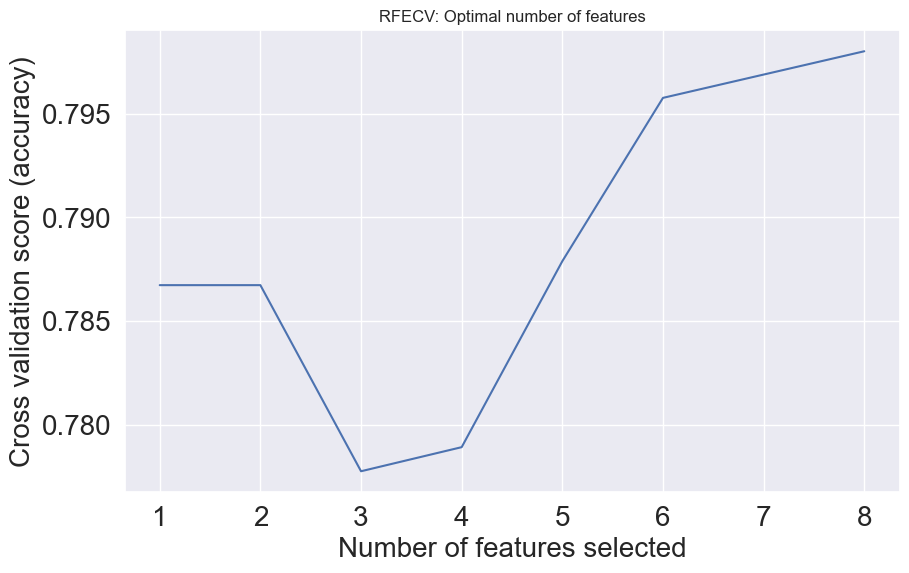

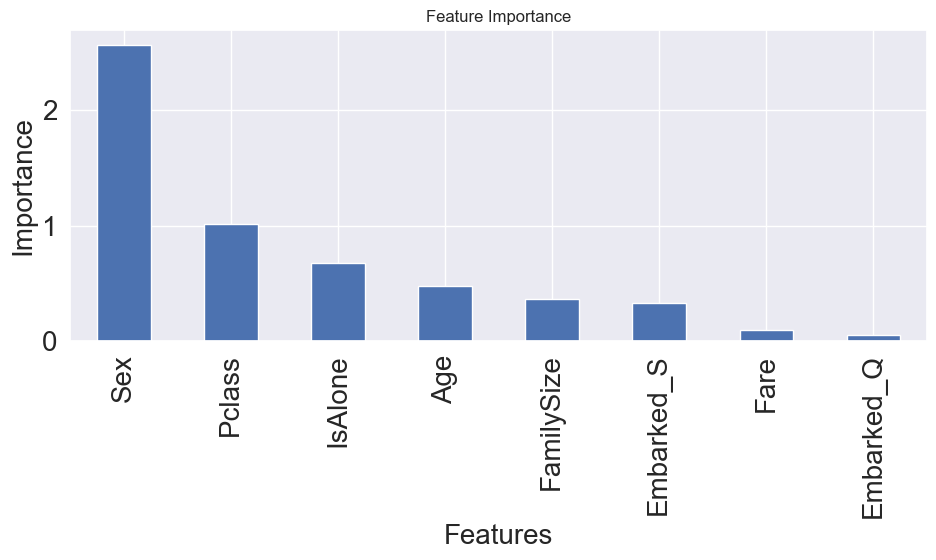

Selected features: ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'IsAlone']

Feature importance:
Sex           2.564081
Pclass        1.017450
IsAlone       0.677817
Age           0.483381
FamilySize    0.370977
Embarked_S    0.334873
Fare          0.096368
Embarked_Q    0.052958
dtype: float64
X Shape:  (891, 8)
X Selected Shape:  (891, 8)
features:  ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']


In [41]:
# Print all the features
print("All features:", X.columns)

# Perform feature selection
best_features, feature_importance = perform_feature_selection(X, t)

print("Selected features:", best_features)
print("\nFeature importance:")
print(feature_importance)

# Update X with selected features
X_selected_features = X[best_features]
print("X Shape: ", X.shape)
print("X Selected Shape: ", X_selected_features.shape)

# Optional select features by amount
n_features_to_select = 7
selected_features = feature_selec(X, t, n_features_to_select)
X_selected_features = X[selected_features]

### Hyper Parameter Search


In [42]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def compare_search_methods(X, t, cv_splits=5, cv_repeats=10, random_state=42):
    """
    Function to compare GridSearchCV and RandomizedSearchCV for parameter optimization of SGDClassifier.
    Performs feature selection using RFECV and plots the comparison graph.
    
    Parameters:
    X (pd.DataFrame): Feature set.
    t (pd.Series): Target variable.
    cv_splits (int): Number of splits for cross-validation.
    cv_repeats (int): Number of repeats for cross-validation.
    random_state (int): Random state for reproducibility.

    Returns:
    dict: Dictionary containing the best hyperparameters and scores for GridSearchCV and RandomizedSearchCV.
    """
    # Feature selection using RFECV
    selector = RFECV(estimator=SGDClassifier(loss='log_loss', random_state=random_state),
                     cv=RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=random_state))
    X_selected_features = pd.DataFrame(selector.fit_transform(X, t), columns=X.columns[selector.support_])
    
    # GridSearchCV
    hyper_parameters_grid = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha': [0.0001, 0.001, 0.01, 0.1]}
    gs_model = GridSearchCV(SGDClassifier(random_state=random_state), hyper_parameters_grid, cv=5)
    gs_model.fit(X_selected_features, t)
    
    # RandomizedSearchCV
    distributions = {'alpha': uniform(loc=0, scale=1), 'penalty': ['l2', 'l1', 'elasticnet']}
    rs_model = RandomizedSearchCV(SGDClassifier(random_state=random_state), distributions, cv=5, random_state=random_state)
    rs_model.fit(X_selected_features, t)
    
    # Print results
    print('GridSearchCV results:')
    print('Accuracy score:', gs_model.best_score_)
    print('Best parameters:', gs_model.best_params_)
    print()
    
    print('RandomizedSearchCV results:')
    print('Accuracy score:', rs_model.best_score_)
    print('Best parameters:', rs_model.best_params_)
    print()
    
    # Plotting the comparison graph
    fig = go.Figure()
    fig.add_trace(go.Bar(name='GridSearchCV', x=['Accuracy'], y=[gs_model.best_score_], marker_color='blue'))
    fig.add_trace(go.Bar(name='RandomizedSearchCV', x=['Accuracy'], y=[rs_model.best_score_], marker_color='orange'))
    fig.update_layout(title='Comparison of GridSearchCV and RandomizedSearchCV',
                      xaxis_title='Search Method',
                      yaxis_title='Accuracy Score',
                      barmode='group')
    fig.show()
    
    # Return the best hyperparameters and scores
    best_params = {
        'GridSearchCV': {
            'best_score': gs_model.best_score_,
            'best_params': gs_model.best_params_
        },
        'RandomizedSearchCV': {
            'best_score': rs_model.best_score_,
            'best_params': rs_model.best_params_
        }
    }
    
    return gs_model, rs_model, best_params




**Grid Search VS Random Search**

In [43]:
# Compare search methods and get best parameters
gs_model, rs_model, best_params = compare_search_methods(X, t)
print(f"Best parameters found: {best_params}")


We can see that the difference is not significant, and the grid search is more expensive than the random search.<br> Despite this, we will stick with the grid search for now.

### Ensembles


#### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize the BaggingClassifier with SGDClassifier as the base estimator
bag_fold_model = BaggingClassifier(
    estimator=SGDClassifier(penalty='elasticnet', alpha=0.001),
    n_estimators=20,
    random_state=1,
    bootstrap=False
).fit(X_selected_features, t)

# Display the accuracy score of the model on the training data
accuracy_score = bag_fold_model.score(X_selected_features, t)
print('Accuracy score for classification with Bagging and SGDClassifier:', accuracy_score)



Accuracy score for classification with Bagging and SGDClassifier: 0.792368125701459


In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, bag_fold_model, k=10, show_score_loss_graphs=True, show_cm=True)

                 Metric Value
      Mean CV Val Score  0.79
  Mean CV Val Loss (CE)  7.46
    Mean CV Train Score  0.80
Mean CV Train Loss (CE)  7.36


#### Bootstrap Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize the BaggingClassifier with SGDClassifier as the base estimator
# and enable bootstrap sampling
bag_fold_model = BaggingClassifier(
    estimator=SGDClassifier(penalty='elasticnet', alpha=0.001),
    n_estimators=20,
    random_state=1,
    bootstrap=True  # Enable bootstrap sampling
).fit(X_selected_features, t)

# Display the accuracy score of the model on the training data
accuracy_score = bag_fold_model.score(X_selected_features, t)
print('Accuracy score for classification with Bootstrap Bagging and SGDClassifier:', accuracy_score)

Accuracy score for classification with Bootstrap Bagging and SGDClassifier: 0.7934904601571269


In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, bag_fold_model, k=10, show_score_loss_graphs=True, show_cm=True)

                 Metric Value
      Mean CV Val Score  0.79
  Mean CV Val Loss (CE)  7.43
    Mean CV Train Score  0.80
Mean CV Train Loss (CE)  7.30


#### Boosting

In [ ]:
# get score with ada boosting
ada_boost_model = AdaBoostClassifier(n_estimators=100, random_state=1).fit(X_selected_features, t)
print('Accuracy score for classification:')
print('ada_boost_model', ada_boost_model.score(X_selected_features, t))

Accuracy score for classification:
ada_boost_model 0.8395061728395061


In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, ada_boost_model, k=10, p=None, show_score_loss_graphs=True)


                 Metric Value
      Mean CV Val Score  0.81
  Mean CV Val Loss (CE)  6.93
    Mean CV Train Score  0.85
Mean CV Train Loss (CE)  5.56


## KNN vs LDA vs NBC